In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from transformers import pipeline, BertTokenizer, BertForSequenceClassification
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import imblearn
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score
import re

In [54]:
#read the train and test data
prefix = '2017_English_final/GOLD/Subtask_A/'
train2013 = pd.read_csv(prefix + 'twitter-2013train-A.txt', header=0, sep = '\t', usecols = [1,2], names = ['sentiment', 'tweet_text'])
train2014 = pd.read_csv(prefix + 'twitter-2014sarcasm-A.txt', header=0, sep = '\t', usecols = [1,2], names = ['sentiment', 'tweet_text'])
train2015 = pd.read_csv(prefix + 'twitter-2015train-A.txt', header=0, sep = '\t', usecols = [1,2], names = ['sentiment', 'tweet_text'])
train2016 = pd.read_csv(prefix + 'twitter-2016train-A.txt', header=0, sep = '\t', usecols = [1,2], names = ['sentiment', 'tweet_text'])

test2013 = pd.read_csv(prefix + 'twitter-2013test-A.txt', header=0, sep = '\t', usecols = [1,2],  names = ['sentiment', 'tweet_text'])
test2014 = pd.read_csv(prefix + 'twitter-2014test-A.txt', header=0, sep = '\t', usecols = [1,2], names = ['sentiment', 'tweet_text'])
test2015 = pd.read_csv(prefix + 'twitter-2015test-A.txt', header=0, sep = '\t', usecols = [1,2], names = ['sentiment', 'tweet_text'])
test2016 = pd.read_csv(prefix + 'twitter-2016test-A.txt', header=0, sep = '\t', usecols = [1,2], names = ['sentiment', 'tweet_text'])

traindf = pd.concat([train2013, train2014, train2015, train2016], ignore_index=True)
testdf = pd.concat([test2013, test2014, test2015, test2016], ignore_index=True)

/share/pkg.7/python3/3.8.10/install/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Sentiment')

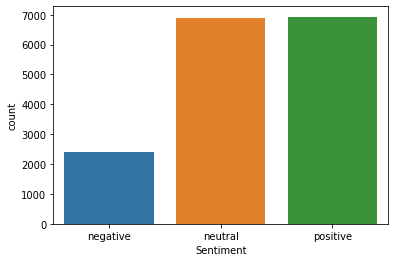

In [55]:
sns.countplot(traindf.sentiment)

plt.xlabel('Sentiment')

In [56]:
def preprocessing(tweet):
    temp = tweet.lower()
    temp = re.sub('@[A-Za-z]+[A-Za-z0-9-_]+', ' ', temp)
    temp = re.sub(r'https\S+', '', temp)
    temp = re.sub(r'http\S+', '', temp)
    temp = re.sub("[0-9]", " ", temp)
    temp = re.sub("\s\s+", " ", temp)
    return temp

print(len(traindf), len(testdf))


traindf = traindf.drop(traindf[traindf.sentiment == 'neutral'].index)
testdf = testdf.drop(testdf[testdf.sentiment == 'neutral'].index)

print(len(traindf), len(testdf))

16250 28418
9355 14908


In [57]:
possible_labels = traindf.sentiment.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

traindf['label'] = traindf.sentiment.replace(label_dict)
testdf['label'] = testdf.sentiment.replace(label_dict)


traindf.to_csv("full_training_data_noneutral.csv",index=True)
testdf.to_csv("full_testing_data_noneutral.csv",index=True)

In [94]:
label_dict

{'negative': 0, 'positive': 1}

In [58]:
#without oversampling
full_training_data = pd.read_csv('full_training_data_noneutral.csv')


X_training_data_imb = full_training_data.tweet_text
Y_training_data_imb = full_training_data.label
full_training_data.head()

,Unnamed: 0,sentiment,tweet_text,label
0,0,negative,Theo Walcott is still shit\u002c watch Rafa an...,0
1,1,negative,its not that I\u2019m a GSP fan\u002c i just h...,0
2,2,negative,Iranian general says Israel\u2019s Iron Dome c...,0
3,5,positive,with J Davlar 11th. Main rivals are team Polan...,1
4,6,negative,Talking about ACT\u2019s && SAT\u2019s\u002c d...,0


In [59]:
#oversampling since there are much less negative sentiment tweets than positive or neutral
oversample = RandomOverSampler(sampling_strategy='minority', random_state = 17)

X_training_data_imb2 = pd.read_csv('full_training_data_noneutral.csv', usecols = [2])
Y_training_data_imb2 = pd.read_csv('full_training_data_noneutral.csv', usecols = [3])

X_training_data_over, Y_training_data_over = oversample.fit_resample(X_training_data_imb2, Y_training_data_imb2)


print(Y_training_data_imb2['label'].value_counts())
print(Y_training_data_over['label'].value_counts())

X_training_data_over2 = X_training_data_over.tweet_text
Y_training_data_over2 = Y_training_data_over.label

#preprocessing the tweets

X_training_data_over2 = [preprocessing(tweet) for tweet in X_training_data_over2]
print(X_training_data_over2[:10])

1    6935
0    2420
Name: label, dtype: int64
0    6935
1    6935
Name: label, dtype: int64
['theo walcott is still shit\\u c watch rafa and johnny deal with him on saturday.', 'its not that i\\u m a gsp fan\\u c i just hate nick diaz. can\\u t wait for february.', 'iranian general says israel\\u s iron dome can\\u t deal with their missiles (keep talking like that and we may end up finding out)', 'with j davlar th. main rivals are team poland. hopefully we an make it a successful end to a tough week of training tomorrow.', 'talking about act\\u s && sat\\u s\\u c deciding where i want to go to college\\u c applying to colleges and everything about college stresses me out.', 'they may have a superbowl in dallas\\u c but dallas ain\\u t winning a superbowl. not with that quarterback and owner. ', ' i just watched it! sridevi\\u s comeback.... u remember her from the s?? sun mornings on nta ;)', 'one of my best th graders kory was excited after his touchdown today!! he did the victor cru

In [60]:
# Remember to change between imb and over
X_training_data_full = X_training_data_over2
Y_training_data_full = Y_training_data_over2

In [61]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)

In [62]:
#encode train
encoded_data_train = tokenizer.batch_encode_plus(X_training_data_full,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                pad_to_max_length = True,
                                                return_tensors = 'pt')

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(Y_training_data_full)


/usr4/cs505/tmei/.local/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2271: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [63]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased',
                                                      num_labels = len(label_dict),
                                                      output_attentions = False,
                                                      output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [64]:
#train set
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)

batch_size = 32
#train set
dataloader_train = DataLoader(dataset_train, sampler = RandomSampler(dataset_train), batch_size = batch_size)

In [65]:
optimizer = AdamW(model.parameters(),
                 lr = 1e-5,
                 eps = 1e-8) #2e-5 > 5e-5
                 
epochs = 10

scheduler = get_linear_schedule_with_warmup(optimizer,
                                           num_warmup_steps = 0,
                                           num_training_steps = len(dataloader_train)*epochs)


/usr4/cs505/tmei/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [66]:
#set seed and device
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda")

In [72]:
#remember to run the cells below first before running this one, need dataloader and evaluate etc...
#also remember to oversample
vallosses = []
predvtrue = []
trainlosses = []

with torch.no_grad():
    torch.cuda.empty_cache()
    
for epoch in tqdm(range(1, epochs+1)):
    
    model.cuda()
    model.train()
    
    loss_train_total = 0
    
# #     progress_bar = tqdm(dataloader_train, 
#                         desc = 'Epoch {:1d}'.format(epoch), 
#                         leave = False, 
#                         disable = False)
    counter = 0
    for batch in dataloader_train:
        
        model.zero_grad() #set gradient to 0
    
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids': batch[0], 
                  'attention_mask': batch[1], 
                  'labels': batch[2]}
        
        outputs = model(**inputs) #unpack the dict straight into inputs
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        counter += 1

    torch.save(model.state_dict(), f'Models/BERTOVER_ft_epoch{epoch}.model')
    
    tqdm.write(f'Epoch {epoch}')
    
    loss_train_ave = loss_train_total / len(dataloader_train)
    print(f'Training loss: {loss_train_ave}')
    trainlosses.append(loss_train_ave)
    
    val_loss, predictions, true_vals = evaluate(dataloader_test)
    print(f'Validation loss: {val_loss}')
    accuracy_per_class(predictions, true_vals)
    
    vallosses.append(val_loss)
    predvtrue.append([predictions, true_vals])

  0%|          | 0/10 [00:54<?, ?it/s]

Epoch 1
Training loss: 0.3173873992593882


 10%|█         | 1/10 [01:10<10:33, 70.42s/it]

Validation loss: 0.20874911988785594
Class: negative
Accuracy:3657/4356 83.95316804407713%
Class: positive
Accuracy:10062/10552 95.35633055344958%


 10%|█         | 1/10 [02:05<10:33, 70.42s/it]

Epoch 2
Training loss: 0.13520133267864928


 20%|██        | 2/10 [02:20<09:24, 70.51s/it]

Validation loss: 0.27436043283414463
Class: negative
Accuracy:3709/4356 85.14692378328742%
Class: positive
Accuracy:9946/10552 94.25701288855194%


 20%|██        | 2/10 [03:15<09:24, 70.51s/it]

Epoch 3
Training loss: 0.06535056155107374


 30%|███       | 3/10 [03:31<08:13, 70.52s/it]

Validation loss: 0.3769697798863193
Class: negative
Accuracy:3600/4356 82.64462809917356%
Class: positive
Accuracy:10057/10552 95.30894617134193%


 30%|███       | 3/10 [04:26<08:13, 70.52s/it]

Epoch 4
Training loss: 0.041563640578761524


 40%|████      | 4/10 [04:42<07:03, 70.51s/it]

Validation loss: 0.42227699761598697
Class: negative
Accuracy:3510/4356 80.57851239669421%
Class: positive
Accuracy:10107/10552 95.78278999241849%


 40%|████      | 4/10 [05:36<07:03, 70.51s/it]

Epoch 5
Training loss: 0.025635446164561735


 50%|█████     | 5/10 [05:52<05:52, 70.45s/it]

Validation loss: 0.4883773777133769
Class: negative
Accuracy:3473/4356 79.72910927456383%
Class: positive
Accuracy:10133/10552 96.02918877937832%


 50%|█████     | 5/10 [06:47<05:52, 70.45s/it]

Epoch 6
Training loss: 0.015787290641166213


 60%|██████    | 6/10 [07:02<04:41, 70.46s/it]

Validation loss: 0.5177093008548109
Class: negative
Accuracy:3555/4356 81.61157024793388%
Class: positive
Accuracy:10071/10552 95.44162244124337%


 60%|██████    | 6/10 [07:57<04:41, 70.46s/it]

Epoch 7
Training loss: 0.01418371703763399


 70%|███████   | 7/10 [08:13<03:31, 70.41s/it]

Validation loss: 0.5353993158710669
Class: negative
Accuracy:3675/4356 84.366391184573%
Class: positive
Accuracy:9974/10552 94.52236542835482%


 70%|███████   | 7/10 [09:07<03:31, 70.41s/it]

Epoch 8
Training loss: 0.008724700511680767


 80%|████████  | 8/10 [09:23<02:20, 70.39s/it]

Validation loss: 0.5320553361949593
Class: negative
Accuracy:3649/4356 83.76951331496785%
Class: positive
Accuracy:10022/10552 94.97725549658831%


 80%|████████  | 8/10 [10:18<02:20, 70.39s/it]

Epoch 9
Training loss: 0.00589367861854538


 90%|█████████ | 9/10 [10:33<01:10, 70.37s/it]

Validation loss: 0.5555228858199952
Class: negative
Accuracy:3613/4356 82.94306703397612%
Class: positive
Accuracy:10028/10552 95.03411675511751%


 90%|█████████ | 9/10 [11:28<01:10, 70.37s/it]

Epoch 10
Training loss: 0.004966232171803895


100%|██████████| 10/10 [11:44<00:00, 70.41s/it]

Validation loss: 0.5582756873848124
Class: negative
Accuracy:3700/4356 84.94031221303948%
Class: positive
Accuracy:9962/10552 94.40864291129644%


In [67]:
#preprocessing test data
full_testing_data = pd.read_csv('full_testing_data_noneutral.csv')

X_testing_data_full = full_testing_data.tweet_text
Y_testing_data_full = full_testing_data.label

X_testing_data_full = [preprocessing(tweet) for tweet in X_testing_data_full]
print(X_testing_data_full[:10])

encoded_data_test = tokenizer.batch_encode_plus(X_testing_data_full,
                                                add_special_tokens = True,
                                                return_attention_mask = True,
                                                padding = True,
                                                return_tensors = 'pt')

input_ids_test = encoded_data_test['input_ids']
attention_masks_test = encoded_data_test['attention_mask']
labels_test = torch.tensor(Y_testing_data_full)

['musical awareness: great big beautiful tomorrow has an ending, now is the time does not', "kapan sih lo ngebuktiin,jan ngomong doang susah susah.usaha aja blm udh nyerah,inget.if you never try you'll never know.cowok kok gentle bgt", 'show your love for your local field & it might win an award! gallagher park #bedlington current th in national award ', ' can you tell me when an update for the apple tv rd gen becomes available? the missing update holds me back from buying #appletv ', " the crown, filthy mcnastys, katy dalys or the duke if york in belfast! can't wait to catch you guys tomorrow night!", 'my #cre blog oklahoma per square foot returns to the blog hub tomorrow. i will have some interesting local data to share.', 'trey burke has been suspended for the northern michigan game (exhibition) tomorrow. ', 'w.o.w wednesday!marni lands this lumberjack vest for the ladies looking to bring a little tom boy toughness ', 'activists in deir ezzor captured this image of musab bin umair m

In [68]:
#test set
dataset_test = TensorDataset(input_ids_test, attention_masks_test, labels_test)

batch_size = 32
#train set

dataloader_test = DataLoader(dataset_test,
                              sampler = RandomSampler(dataset_test),
                              batch_size = 32) 

In [69]:
labels_test

tensor([1, 0, 1,  ..., 1, 1, 0])

In [71]:
def evaluate(dataloader_test):

    #evaluation mode 
    model.eval()
    
    #tracking variables
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_test:
        
        #load into GPU
        batch = tuple(b.to(device)  for b in batch)
        
        #define inputs
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2]}

        #compute logits
        with torch.no_grad():        
            outputs = model(**inputs)
        
        #compute loss
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        #compute accuracy
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    #compute average loss
    loss_val_avg = loss_val_total/len(dataloader_test) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        percent = (len(y_preds[y_preds==label]) / len(y_true)) * 100
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)} {percent}%')

In [30]:
#You don't need to run this cell and the ones below for the training
#No need to run this cell if you've just trained the model in current session
vallosses = []
predvtrue = []

#validation losses
for i in range(1,epochs+1):
    model.load_state_dict(torch.load(f'Models/BERTOVER_ft_epoch{i}.model'))
    val_loss, predictions, true_vals = evaluate(dataloader_test)
    vallosses.append(val_loss)
    predvtrue.append([predictions, true_vals])

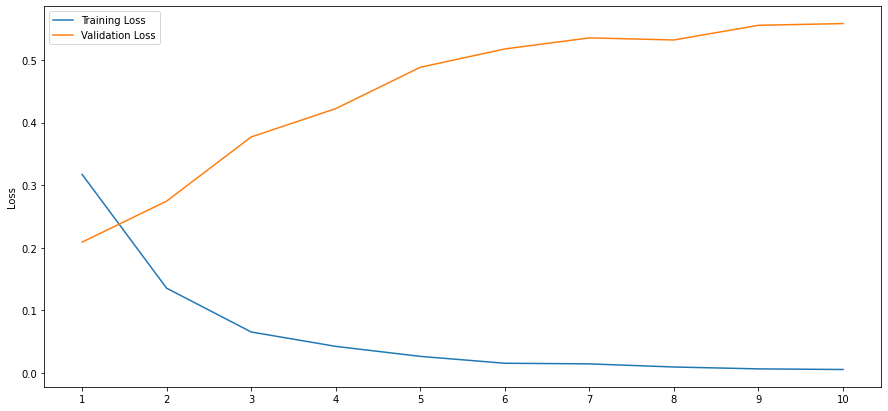

In [88]:
#Plot the training and validation loss
plt.figure(figsize=(15, 7))
RANGE = range(1, 11)
#trainlosses =  [0.317, 0.135, 0.065, 0.042, 0.026, 0.015, 0.014, 0.009, 0.006, 0.005]
plt.plot(RANGE, trainlosses,
         label = "Training Loss")
plt.plot(RANGE, vallosses, label = "Validation Loss")

plt.xticks(RANGE)
plt.ylabel('Loss')
plt.legend()
plt.show()

In [89]:
#Predictions for calculating F1score, just reusing code from accuracyscore
predvtrue2 = []

def predictions(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    #make prediction
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
    
    return y_preds, y_true

for preds, labels in predvtrue:
    predlabels, truelabels = predictions(preds, labels)
    predvtrue2.append([predlabels,truelabels])

In [90]:
#Calculating F1 Scores
f1scores = []
for i in range(len(predvtrue2)):
    f1scores.append(f1_score(predvtrue2[i][0], predvtrue2[i][1], average='weighted'))

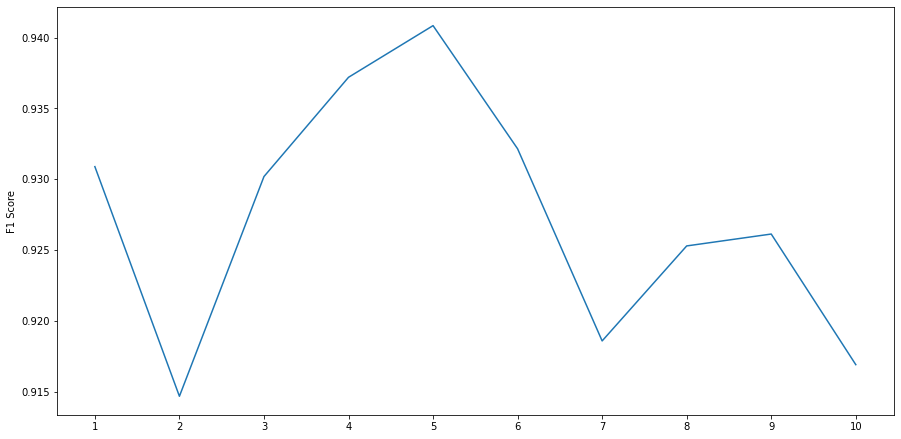

Max F1 Score at Epoch 5: 0.9408399999047043


In [93]:
#Plotting F1 Scores
plt.figure(figsize=(15, 7.5))
plt.plot(RANGE, f1scores)
plt.ylabel('F1 Score')
plt.xticks(RANGE)
plt.show()
max_value = max(f1scores)
max_index = f1scores.index(max_value) + 1
print(f"Max F1 Score at Epoch {max_index}: {max_value}")